In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torchinfo
import glob
from pprint import pprint
from skimage.io import imread
from torch.utils.data import DataLoader
import utils
from models import HumerusDataset, Rescale, NoneTransform, BaselineNN, HistEqualizationTransform
import torch
from torch import nn
import torchvision
print(f'Pytorch version: {torch.__version__}, Torchvision version: {torchvision.__version__}')

Pytorch version: 2.0.0+cpu, Torchvision version: 0.15.1+cpu


In [2]:
path=glob.glob(os.path.join('MURA-v1.1','*','*','*', '*','*.png'))
pprint(path)


['MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00031\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00031\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00034\\study1_positive\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00034\\study1_positive\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient0

We try to concatenate all the info about the images in one dataset
We use the character '\\' because one '\' is the escape and the other separates the subfolders in our OS (Windows). if we worked in linux we would use the character '/'
THere are two studies :study 1 and study 2

In [3]:
everythingScans_df=pd.DataFrame(dict(path=path))
everythingScans_df['Split']=everythingScans_df['path'].map(lambda x:x.split('\\')[1])
everythingScans_df['Bone']=everythingScans_df['path'].map(lambda x:x.split('\\')[2])
everythingScans_df['Patient']=everythingScans_df['path'].map(lambda x:x.split('\\')[3])
everythingScans_df['FolderName']=everythingScans_df['path'].map(lambda x:x.split('\\')[4])
everythingScans_df['Study']=everythingScans_df['path'].map(lambda x:x.split('\\')[4].split('_')[0])
everythingScans_df['Label']=everythingScans_df['path'].map(lambda x:x.split('\\')[4].split('_')[1])
everythingScans_df.sample(10)

path  Split         Bone  \
8088   MURA-v1.1\train\XR_FINGER\patient04124\study1_...  train    XR_FINGER   
34813  MURA-v1.1\train\XR_WRIST\patient08425\study1_n...  train     XR_WRIST   
10197  MURA-v1.1\train\XR_FOREARM\patient02782\study1...  train   XR_FOREARM   
15675  MURA-v1.1\train\XR_HAND\patient10555\study1_ne...  train      XR_HAND   
39526  MURA-v1.1\valid\XR_WRIST\patient11234\study1_p...  valid     XR_WRIST   
6129   MURA-v1.1\train\XR_FINGER\patient03440\study1_...  train    XR_FINGER   
34610  MURA-v1.1\train\XR_WRIST\patient08358\study1_n...  train     XR_WRIST   
35965  MURA-v1.1\train\XR_WRIST\patient08802\study1_n...  train     XR_WRIST   
22472  MURA-v1.1\train\XR_SHOULDER\patient01228\study...  train  XR_SHOULDER   
18857  MURA-v1.1\train\XR_SHOULDER\patient00058\study...  train  XR_SHOULDER   

            Patient       FolderName   Study     Label  
8088   patient04124  study1_negative  study1  negative  
34813  patient08425  study1_negative  study1  negative  
10197  patient02782  study1_negative  study1  negative  
15675  patient10555  study1_negative  study1  negative  
39526  patient11234  study1_positive  study1  positive  
6129   patient03440  study1_positive  study1  positive  
34610  patient08358  study1_negative  study1  negative  
35965  patient08802  study1_negative  study1  negative  
22472  patient01228  study1_positive  study1  positive  
18857  patient00058  study2_negative  study2  negative

We check if some data is missing

In [4]:
print(everythingScans_df.isnull().values.any())
a=[0 if (x=='positive' or x=='negative') else 1 for x in everythingScans_df['Label'] ]
print(sum(a))

False
0


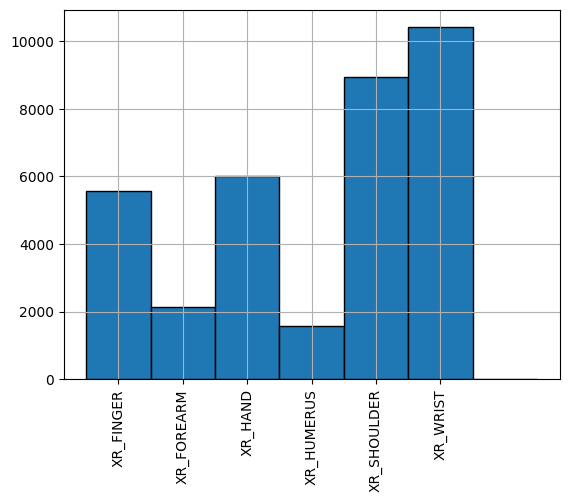

In [5]:

everythingScans_df['Bone'].hist(bins=range(1,9),rwidth=1, align='left',edgecolor='black')
plt.xticks(rotation=90)
plt.show()

# Explore some examples of images
When groupping by two values we need to define how the values will be combined.
get combinations of pics with same label and bone then choose one randomly 

In [6]:
onePairPic_df=everythingScans_df.groupby(['Label','Bone']).apply(lambda x:x.sample(1))
onePairPic_df.reset_index(drop=True)

path  Split         Bone  \
0   MURA-v1.1\train\XR_ELBOW\patient00011\study1_n...  train     XR_ELBOW   
1   MURA-v1.1\train\XR_FINGER\patient04687\study1_...  train    XR_FINGER   
2   MURA-v1.1\train\XR_FOREARM\patient09634\study1...  train   XR_FOREARM   
3   MURA-v1.1\train\XR_HAND\patient10848\study1_ne...  train      XR_HAND   
4   MURA-v1.1\train\XR_HUMERUS\patient03089\study1...  train   XR_HUMERUS   
5   MURA-v1.1\valid\XR_SHOULDER\patient11765\study...  valid  XR_SHOULDER   
6   MURA-v1.1\train\XR_WRIST\patient05045\study1_n...  train     XR_WRIST   
7   MURA-v1.1\valid\XR_ELBOW\patient11809\study1_p...  valid     XR_ELBOW   
8   MURA-v1.1\valid\XR_FINGER\patient11480\study1_...  valid    XR_FINGER   
9   MURA-v1.1\train\XR_FOREARM\patient07091\study1...  train   XR_FOREARM   
10  MURA-v1.1\train\XR_HAND\patient09761\study1_po...  train      XR_HAND   
11  MURA-v1.1\train\XR_HUMERUS\patient02710\study1...  train   XR_HUMERUS   
12  MURA-v1.1\train\XR_SHOULDER\patient01097\study...  train  XR_SHOULDER   
13  MURA-v1.1\train\XR_WRIST\patient07243\study1_p...  train     XR_WRIST   

         Patient       FolderName   Study     Label  
0   patient00011  study1_negative  study1  negative  
1   patient04687  study1_negative  study1  negative  
2   patient09634  study1_negative  study1  negative  
3   patient10848  study1_negative  study1  negative  
4   patient03089  study1_negative  study1  negative  
5   patient11765  study1_negative  study1  negative  
6   patient05045  study1_negative  study1  negative  
7   patient11809  study1_positive  study1  positive  
8   patient11480  study1_positive  study1  positive  
9   patient07091  study1_positive  study1  positive  
10  patient09761  study1_positive  study1  positive  
11  patient02710  study1_positive  study1  positive  
12  patient01097  study1_positive  study1  positive  
13  patient07243  study1_positive  study1  positive

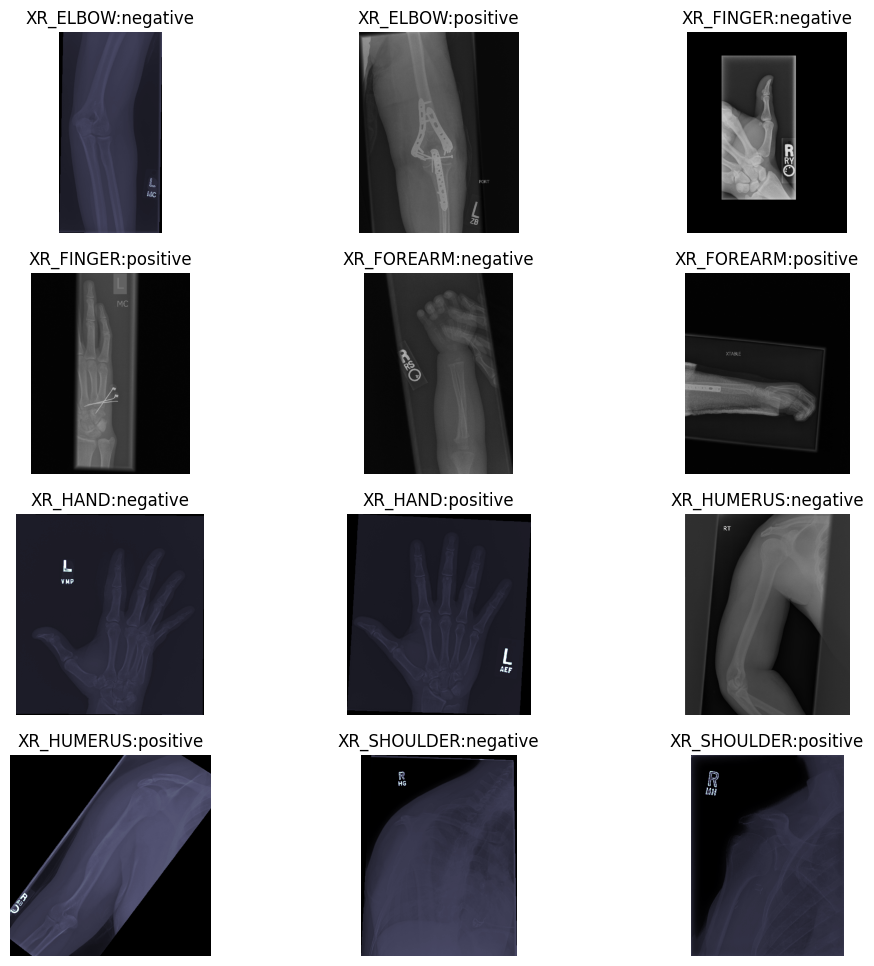

In [9]:
sub_df = everythingScans_df.groupby(['Bone', 'Label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{Bone}:{Label}'.format(**c_row))

In [8]:
# try working only on humerus

humerus_df=everythingScans_df.loc[everythingScans_df['Bone']=='XR_HUMERUS'].copy()
humerus_df.sample(10)

path  Split        Bone  \
17618  MURA-v1.1\train\XR_HUMERUS\patient02736\study1...  train  XR_HUMERUS   
38773  MURA-v1.1\valid\XR_HUMERUS\patient11698\study1...  valid  XR_HUMERUS   
18516  MURA-v1.1\train\XR_HUMERUS\patient03146\study1...  train  XR_HUMERUS   
17476  MURA-v1.1\train\XR_HUMERUS\patient01768\study1...  train  XR_HUMERUS   
17750  MURA-v1.1\train\XR_HUMERUS\patient02794\study1...  train  XR_HUMERUS   
17970  MURA-v1.1\train\XR_HUMERUS\patient02892\study1...  train  XR_HUMERUS   
18397  MURA-v1.1\train\XR_HUMERUS\patient03091\study1...  train  XR_HUMERUS   
17489  MURA-v1.1\train\XR_HUMERUS\patient01856\study1...  train  XR_HUMERUS   
18024  MURA-v1.1\train\XR_HUMERUS\patient02916\study1...  train  XR_HUMERUS   
38699  MURA-v1.1\valid\XR_HUMERUS\patient11666\study1...  valid  XR_HUMERUS   

            Patient       FolderName   Study     Label  
17618  patient02736  study1_positive  study1  positive  
38773  patient11698  study1_negative  study1  negative  
18516  patient03146  study1_negative  study1  negative  
17476  patient01768  study1_positive  study1  positive  
17750  patient02794  study1_positive  study1  positive  
17970  patient02892  study1_positive  study1  positive  
18397  patient03091  study1_negative  study1  negative  
17489  patient01856  study1_positive  study1  positive  
18024  patient02916  study1_positive  study1  positive  
38699  patient11666  study1_negative  study1  negative

c:\Users\pchrk\OneDrive\Desktop\pms cs\NLP\NLP\nlp_venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 256, 256]) 0
<class 'torch.Tensor'>


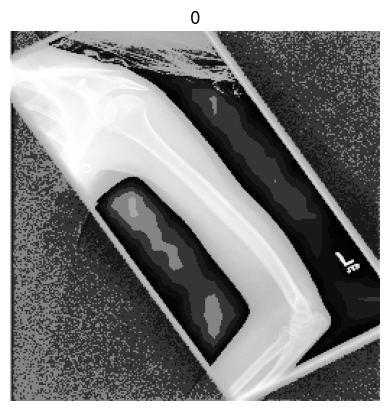

In [11]:
#DO NOT add transforms.ToTensor() to the transform list!
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256,256]),
    HistEqualizationTransform(),
    
])

img, label = HumerusDataset(humerus_df,data_transforms).__getitem__(2)
#shape attributed evaluated at runtime depending on the dataset implementation

print(img.shape, label)
print(type(img))
utils.show_image_w_label(img, label)

In [20]:
BATCH_SIZE=32
transormation=torchvision.transforms.Compose([
    torchvision.transforms.Resize([256,256]),
    #HistEqualizationTransform(),
])

train_dataloader=DataLoader(HumerusDataset(humerus_df.loc[humerus_df['Split']=='train'].copy(),transform=transormation), batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader=DataLoader(HumerusDataset(humerus_df.loc[humerus_df['Split']=='valid'].copy(),transform=transormation), batch_size=BATCH_SIZE, shuffle=True)


# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, valid_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(valid_dataloader)} batches of {BATCH_SIZE}")

# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000002473F3A41F0>, <torch.utils.data.dataloader.DataLoader object at 0x000002473F3A4C70>)
Length of train dataloader: 40 batches of 32
Length of test dataloader: 9 batches of 32


c:\Users\pchrk\OneDrive\Desktop\pms cs\NLP\NLP\nlp_venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([32, 3, 256, 256]), torch.Size([32]))

In [68]:
def train(model, dataloader, loss_fn, optimizer, num_epochs=5, pretrained=False):

    #put in training mode
    model.train()
    #reset model parameters
    if not pretrained:
        model.reset_parameters()


    loss_history=[]
    for epoch in range(num_epochs):
        loss_per_epoch=0


        print(f"Epoch {epoch+1}/{num_epochs}")

        #batch computations
        for i, (inputs, labels) in enumerate(dataloader):
            print("batch number",i)
            if pretrained:
                pass
            else:
                inputs=inputs.view(inputs.shape[0],-1)
            print(inputs.shape,inputs.dtype)
            if pretrained:
                outputs=model(inputs).squeeze()
            else:
                outputs=model(inputs)
            print(outputs)
            print(outputs.shape,outputs.dtype)
            print(labels.shape,labels.dtype)
            labels=labels.type_as(outputs)

            #loss returns mean loss per batch unless specified otherwise
            batch_loss=loss_fn(outputs,labels)

            #add the batch_loss to epoch loss
            loss_per_epoch+=batch_loss.item()

            optimizer.zero_grad()
            #update parameters
            batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            #print(i, loss.item())
            # if i%8==0:
            #     print(f"Loss at iteration {i} is {round((loss_per_epoch/8),4)}")
            #     #loss_istory has acumulated the mean loss of 8 batches so we divide by 4 to get 
            #     # avg loss per batch
            #     loss_history.append(round((loss_per_epoch/8),4))
            #     loss_per_epoch=0
            if i % 9 == 0:
                print(f"Cumuative Loss at batch {i} is {round((loss_per_epoch/9),4)}")


        print(f"Loss at epoch {epoch+1} is {round((loss_per_epoch/len(dataloader)),4)}")
        loss_history.append(round((loss_per_epoch/len(dataloader)),4))
    return loss_history
    
@torch.no_grad()    
def evaluate(model, dataloader, loss_fn,accuracy_fn):
    model.eval()

    loss_history=[]
    eval_loss=0
    eval_acc=0
    
    for i, (inputs, labels) in enumerate(dataloader):
        inputs=inputs.view(inputs.shape[0],-1)
        if pretrained:
            outputs=model(inputs).squeeze()
        else:
            outputs=model(inputs)
        labels=labels.type_as(outputs)
        loss=loss_fn(outputs,labels)
        eval_loss+=loss.item()
        eval_acc+=accuracy_fn(outputs,labels)

        loss_history.append(round(loss.item(),4))
    eval_loss=eval_loss/len(dataloader)
    eval_acc=eval_acc/len(dataloader)
    print(f"\n Test loss: {eval_loss:.5f}, Test acc: {eval_acc:.2f}%\n")
    return loss_history

In [ ]:
#train_features_batch, train_labels_batch = next(iter(train_dataloader))
## explain why train_features_batch does not have the correct dimensions when applying shape????

In [ ]:
input_size = 3*train_features_batch.shape[2]*train_features_batch.shape[3]
print(f"Input size: {input_size}")
loss_fn=torch.nn.BCELoss(reduction='mean')
model=BaselineNN(input_size=input_size, hidden_size=128, output_size=1)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

train_loss_history=train(model, train_dataloader, loss_fn, optimizer, num_epochs=10)
valid_loss_history=evaluate(model, valid_dataloader, loss_fn,accuracy_fn=utils.accuracy_fn)




In [ ]:
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')

In [40]:
transormation_dict= {

    'train':torchvision.transforms.Compose([]),
    
    
    'train_resnet': torchvision.transforms.Compose(
        [torchvision.transforms.Resize([256,256]),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        
    ]
    )


}

In [66]:
#freeze all layers
#use weights and default so as not to get warnings
#use pretrained weights
weights=torchvision.models.ResNet18_Weights.DEFAULT
resnet18 = torchvision.models.resnet18(weights=weights)
for param in resnet18.parameters():
    param.requires_grad=False

weights.transforms()
in_features=resnet18.fc.in_features
resnet18.fc=torch.nn.Linear(in_features,1)
#torchinfo.summary(resnet18, input_size=(32, 3, 256, 256),col_names=["input_size", "output_size", "num_params", "trainable"], verbose=2)

In [69]:

optimizer=torch.optim.Adam(resnet18.fc.parameters(),lr=0.001)
input_size = 3*train_features_batch.shape[2]*train_features_batch.shape[3]
print(f"Input size: {input_size}")
loss_fn=torch.nn.BCEWithLogitsLoss(reduction='mean')
model=resnet18
optimizer=torch.optim.Adam(model.fc.parameters(),lr=0.001)

train_loss_history=train(model, train_dataloader, loss_fn, optimizer, num_epochs=10, pretrained=True)
valid_loss_history=evaluate(model, valid_dataloader, loss_fn,accuracy_fn=utils.accuracy_fn)




Input size: 196608
Epoch 1/10


c:\Users\pchrk\OneDrive\Desktop\pms cs\NLP\NLP\nlp_venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


batch number 0
torch.Size([32, 3, 256, 256]) torch.float32
tensor([-0.6562, -0.4530,  0.2423,  0.0762, -0.8381, -0.7518, -1.1403, -0.7692,
        -0.6059, -0.6092, -0.9388, -0.7185, -0.5937, -0.6913,  0.3912, -0.5047,
        -0.6079, -0.6211, -0.4213, -0.4848, -0.4576,  0.4440, -0.5319, -0.4996,
        -0.4775, -0.4228, -0.6039, -0.7721, -0.8923,  0.2750, -0.6079, -1.0409],
       grad_fn=<SqueezeBackward0>)
torch.Size([32]) torch.float32
torch.Size([32]) torch.int64
Cumuative Loss at batch 0 is 0.0801
batch number 1
torch.Size([32, 3, 256, 256]) torch.float32
tensor([-0.0173,  0.0819, -0.5879,  0.9603,  0.0121, -0.5216, -0.5958,  0.5099,
         0.0239,  0.3742, -0.7994, -0.4555, -0.1945, -0.2778, -0.6370, -0.1019,
        -0.3476,  0.1831,  0.0571,  0.1679, -0.0645, -0.5518, -0.4718, -0.2413,
        -0.7890, -0.2311, -0.3375, -0.2878,  0.0454,  0.1222, -0.5292,  0.2079],
       grad_fn=<SqueezeBackward0>)
torch.Size([32]) torch.float32
torch.Size([32]) torch.int64
batch number 2

In [54]:
dd,d2=next(iter(train_dataloader))
print(dd.shape)

c:\Users\pchrk\OneDrive\Desktop\pms cs\NLP\NLP\nlp_venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([32, 3, 256, 256])
